# MOD 3: Final Project Submission
* Student name: Bryan DiCarlo
* Student pace: Full Time Online 4/15/19 Cohort
* Scheduled project review date/time: Monday July 22 9-10am
* Instructor name: Rafael Carrasco
* Blog post URL: https://bryan-dicarlo.github.io/diagnostic_cardiotocography_with_machine_learning

# Introduction: ML Based Diagnostic Tool for Evaluating CTG
* Cardiotocograhy (CTG) is a technical means of recording the fetal heartbeat and the uterine contractions during pregnancy.
* CTG is commonly used to monitor fetal wellbeing 
* Results are interpreted by a physician using the following guidelines set by International Federation of Gynaecology and Obstetrics (FIGO)

# Updated 2015 FIGO Intrapartum Fetal Monitoring Guidelines
- **Normal**: No hypoxia/acidosis, no intervention necessary to improve fetal oxygenation state:
    * Baseline 110-160 bpm
    * Variability 5-25 bpm
    * No repetitive decelerations (decelerations are defined as repetitive when associated with > 50% contractions)
    
- **Suspicious**: Low probability of hypoxia/acidosis, warrants action to correct reversible causes if identified, close monitoring or adjunctive methods:
    * Lacking at least one characteristic of normality, but with no pathological features.
    
- **Pathological**: High probability of hypoxia/acidosis, requires immediate action to correct reversible causes, adjunctive methods, or if this is not possible expedite delivery. In acute situations immediate delivery should be accomplished
    * Deceleration > 5 min
    * Baseline <100 bpm
    * Reduced or increased variability or sinusoidal pattern
    * Repetitive late or prolonged decelerations for > 30 min, or > 20 min if reduced variability (decelerations are defined as repetitive when associated with > 50% contractions) [Wikipedia](https://en.wikipedia.org/wiki/Cardiotocography)
    

# Features of the CTG Dataset
<img src='features.png'>

# The Dataset
- The CTG Dataset has 2126 different CTG test results. Each evaluated and scored by a physician
- [Cardiotocography Data Set](https://archive.ics.uci.edu/ml/datasets/cardiotocography)
- The evaluations are based on the 21 feature observations (listed above) of each CTG test.
- The physicians then classified each test into one of three categories according to FIGO guidelines
    * Normal
    * Suspicious
    * Pathological

# Objective and Methodology
* We will develop a machine learning model, as a diagnostic tool, for effectively classifying CTG test results
* We will use a supervised Machine Learning approach. Models will be trained to predict three outcome categories(Normal (1), Suspicious (2), Pathological (3)) using 70%  of the dataset of the target labeled dataset.
* The model will then be evaluated by its ability to predict classes for the remaining 30% of unseen data.
* The most promising models will be further scrutinized using 10-fold cross validation for each of the four most important metrics: F1 score, Precision, Recall and Accuracy.
* The best performing model will have high and consistent results for all 4 of these 10 fold cross validated metrics
* This will give us high confidence that the model performs well across the entire dataset and that our results are not anamalous.

## EDA

In [84]:
# Imports
from imblearn.over_sampling import SMOTE, ADASYN
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold, cross_val_score
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set_style("darkgrid")

## Read the CTG Data

In [85]:
# Read the CTG data into a Pandas DataFrame
df_a = pd.read_csv('CTG.csv')
df_a.shape

(2126, 23)

In [86]:
#Prepare the Data for SMOTE
X_a = df_a.drop(['NSP'], axis=1)
y_a = df_a.NSP
print(X_a.shape, y_a.shape)

(2126, 22) (2126,)


## Inspect The Class Imbalance

In [87]:
# Value Counts to inspect the Imbalance
y_a.value_counts()

1    1655
2     295
3     176
Name: NSP, dtype: int64

## Address the Imbalance with Synthetic Minority Oversampling SMOTE

In [88]:
# SMOTE resampling
X_resampled, y_resampled = SMOTE(random_state=10).fit_sample(X_a, y_a)

In [89]:
# Return the features and target back into a Pandas DataFrames
df_X = pd.DataFrame(X_resampled, columns=X_a.columns)
df_y = pd.DataFrame(y_resampled, columns=['NSP'])

In [90]:
# Concatenate the resampled features and target into one DataFrame
df = pd.concat([df_X, df_y], axis=1)
df.head(2)

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,CLASS,NSP
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,9.0,2
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,6.0,1


In [91]:
# Inspect the shape of the new DataFrame
df.shape

(4965, 23)

## We Now have Balanced Classes for Modeling

In [92]:
# Inspect the new balanced Target Classes
df.NSP.value_counts()

3    1655
2    1655
1    1655
Name: NSP, dtype: int64

## We can see a difference in scale.  I will be using the Robust Scaler which will be efffective for scaling as well as robust treatment of outliers.  We need to adress both issues for the Models that will be most effective for this data set.

In [93]:
# Confirm and view features DataFrame head
feat = df.drop(['CLASS','NSP'], axis=1)
feat.head()

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,64.0,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,130.0,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,130.0,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,117.0,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,117.0,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0


## Visualize The Un-Scaled Features

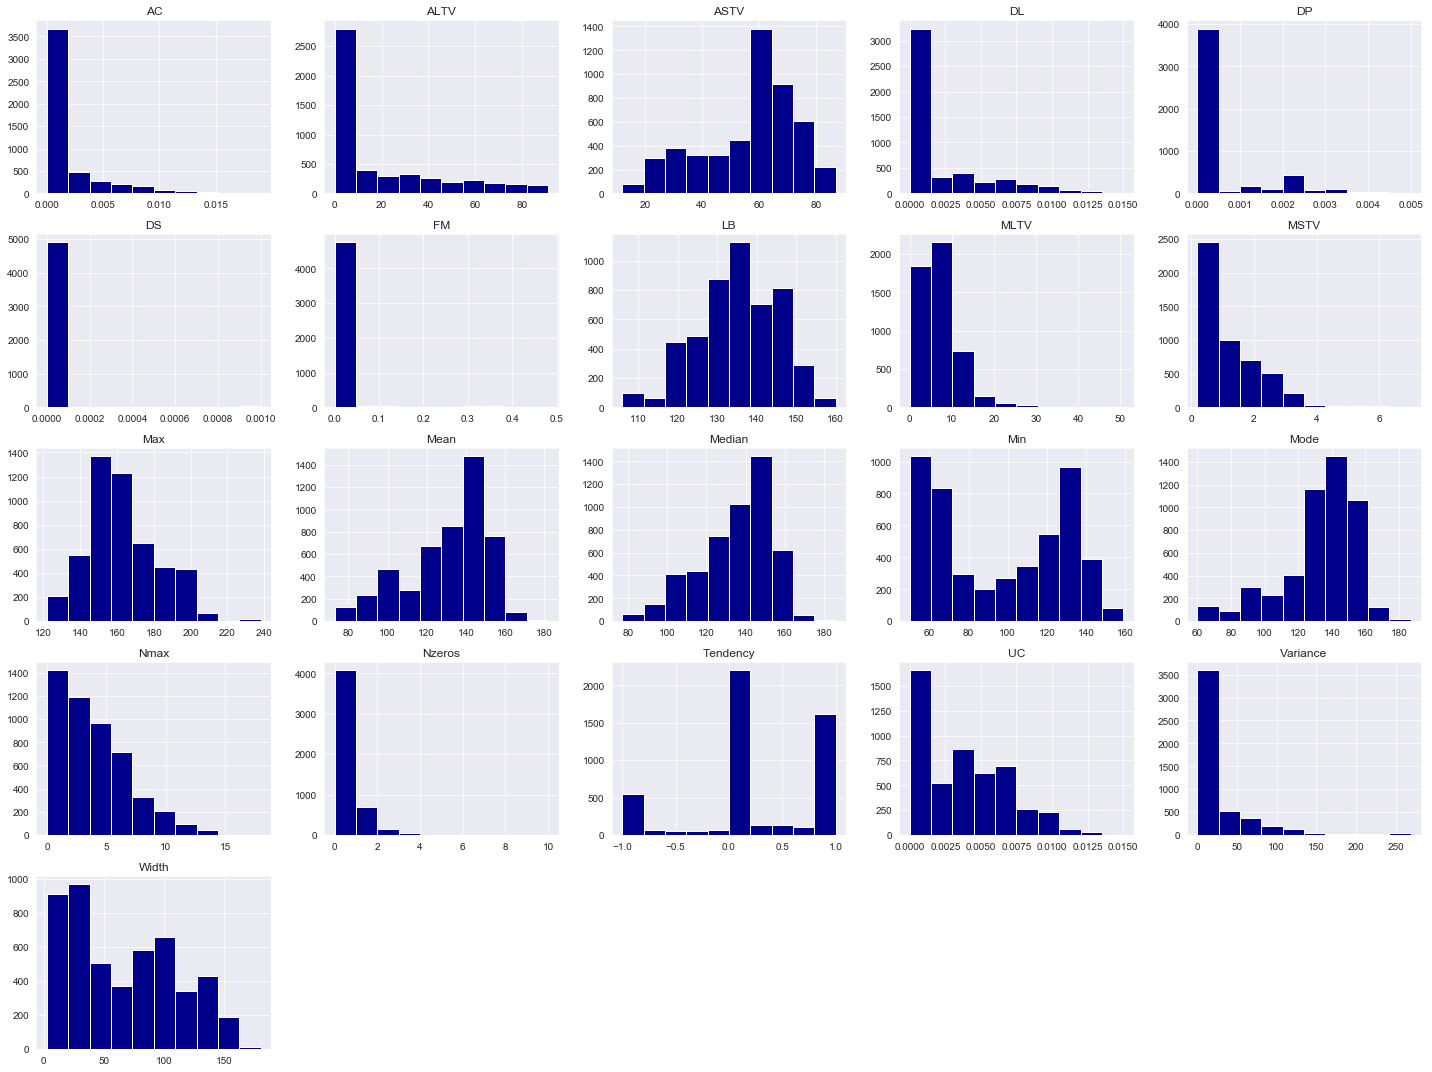

In [94]:
# Visualize un-scaled features
feat.hist(figsize=(20,15), color="darkblue")
plt.tight_layout()
plt.show()

## Boxplot to Visualize the Un-Scaled Features

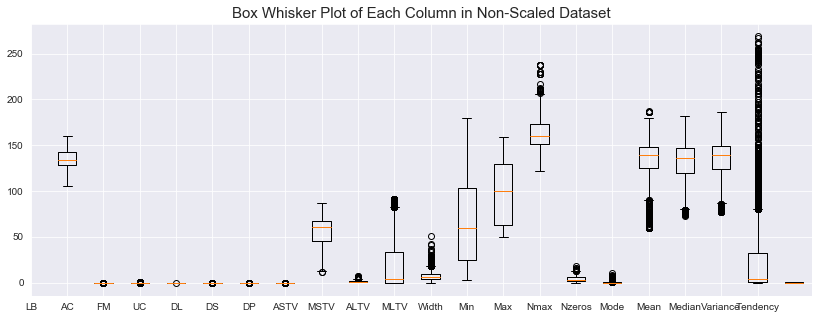

In [95]:
plt.figure(figsize=(14, 5))
plt.boxplot([feat[col] for col in feat.columns])
plt.title("Box Whisker Plot of Each Column in Non-Scaled Dataset", fontsize=15)
plt.xticks(range(len(feat.columns.values)), feat.columns.values)
plt.show()

## Preprocessing

### Use RobustScaler to scale features.  This will scale and remove outliers in a way needed for our ML models.  Also uses statistics that are robust to outliers which can affect certain ML algorithms.

In [96]:
# Scale features using RobustScaler
feat2 = df.drop(['CLASS','NSP'], axis=1)
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
feat2[feat2.columns] = scaler.fit_transform(feat2[feat2.columns])



In [97]:
# Scaled Features: to handle scale/distance imbalance as well as outliers
feat2.head()

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency
0,-0.937210,0.0,-0.202612,-0.586393,0.0,0.0,0.0,0.548359,-0.285714,1.174496,...,0.051282,-0.575758,-1.495043,-0.227539,0.000000,-0.815703,0.037404,-0.721411,2.188566,1.0
1,-0.135458,3.0,-0.202612,0.534686,1.0,0.0,0.0,-2.010648,0.857143,-0.125148,...,0.897436,-0.484848,1.702907,0.616222,4.660002,0.085863,0.000000,0.037131,0.253747,0.0
2,-0.068646,1.5,-0.202612,0.908379,1.0,0.0,0.0,-2.056345,0.857143,-0.125148,...,0.897436,-0.484848,1.702907,0.405282,4.660002,0.085863,-0.037404,-0.042715,0.285465,0.0
3,-0.001833,1.5,-0.202612,0.908379,1.0,0.0,0.0,-2.056345,1.071429,-0.125148,...,0.730769,-0.712121,0.459260,1.670922,0.000000,-0.085863,-0.074808,-0.082639,0.285465,1.0
4,-0.135458,3.5,-0.202612,0.908379,0.0,0.0,0.0,-2.056345,1.071429,-0.125148,...,0.730769,-0.712121,0.459260,1.249042,0.000000,-0.085863,0.000000,-0.042715,0.222028,1.0


## Visualization of the Scaled Features Using the RobustSaler

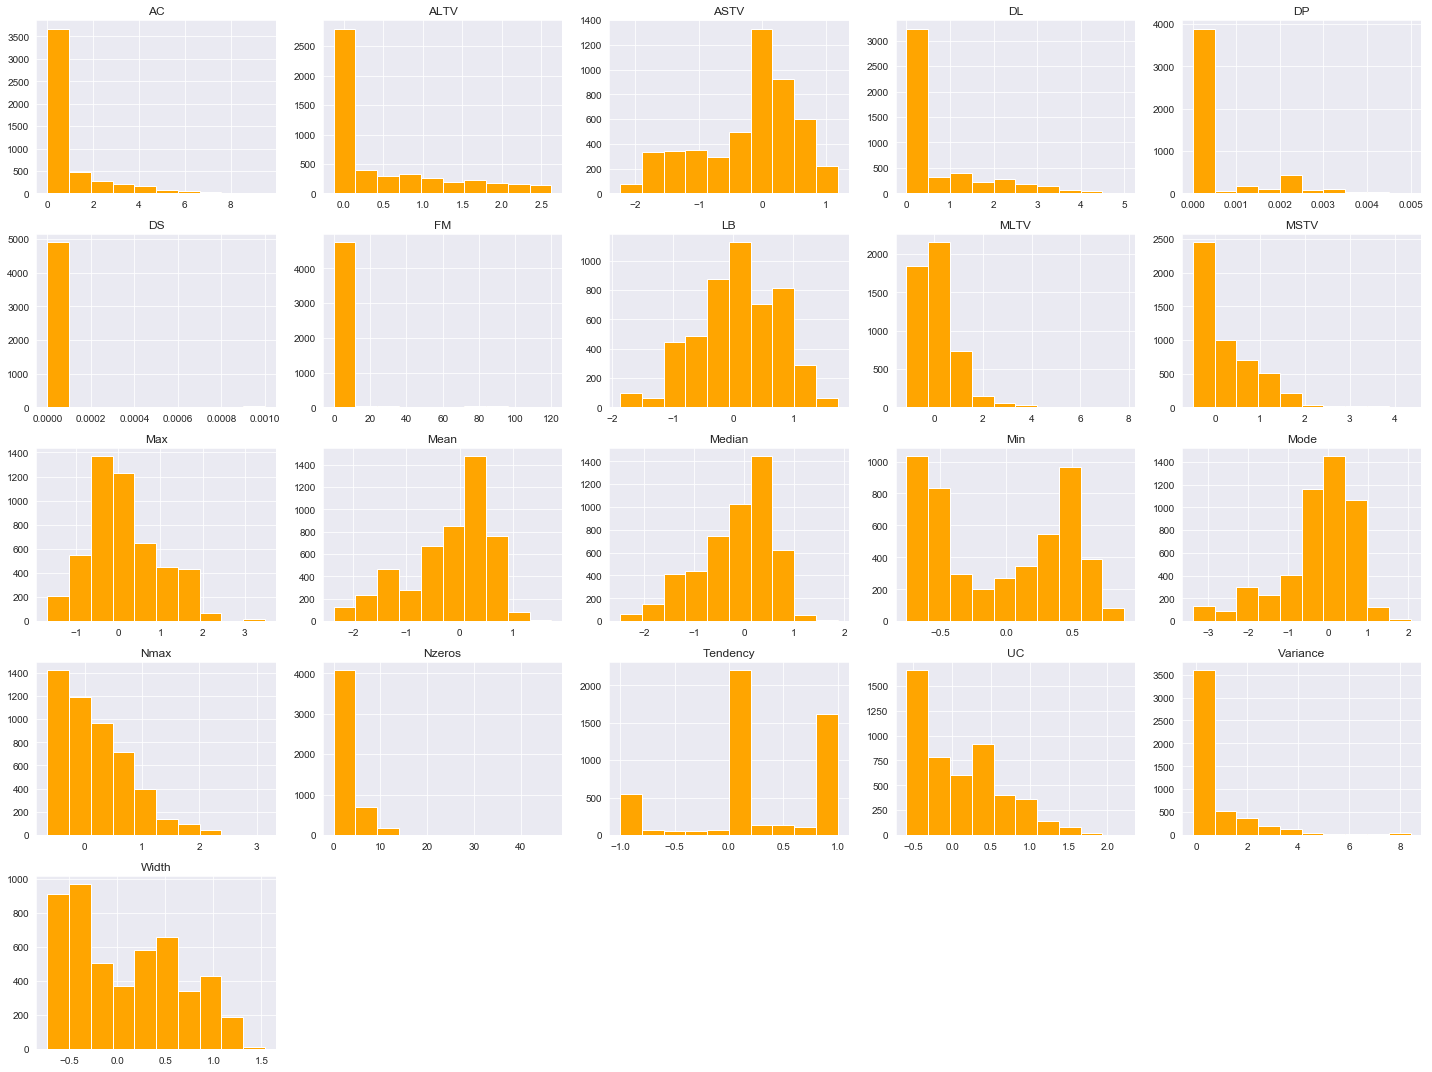

In [98]:
# Visualization of the Scaled Features
feat2.hist(figsize=(20,15), color="orange")
plt.tight_layout()
plt.show()

## Boxplot to Visualize the Scaled Features

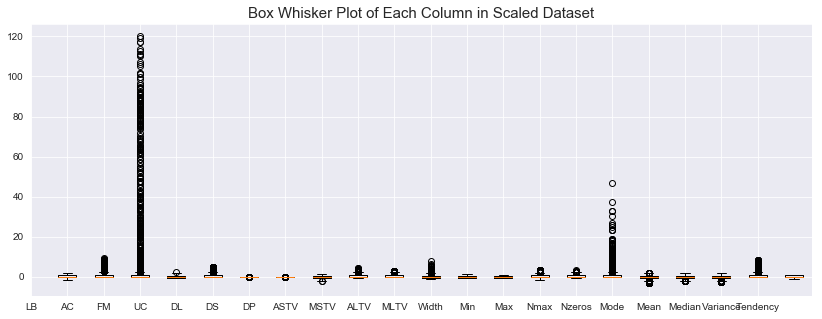

In [99]:
# Create a Box Whisker Plot of each column
plt.figure(figsize=(14, 5))
plt.boxplot([feat2[col] for col in feat2.columns])
plt.title("Box Whisker Plot of Each Column in Scaled Dataset", fontsize=15)
plt.xticks(range(len(feat2.columns.values)), feat2.columns.values)
plt.show()

### As we can see after scaling our features are all much closer to same scale.  Much better for modeling.
* Scale and outliers have both been adressed.
* Should be noted that the UC and mode features still have outliers.  However keep in mind the scale is still small numbers.
* As we will see in our feature importance plot UC or mode will likely not be very useful to the model and likely not to be included
* All other features have been reduced to the same scale and outliers have been minimized

## Correlation Matrix for Features and Target

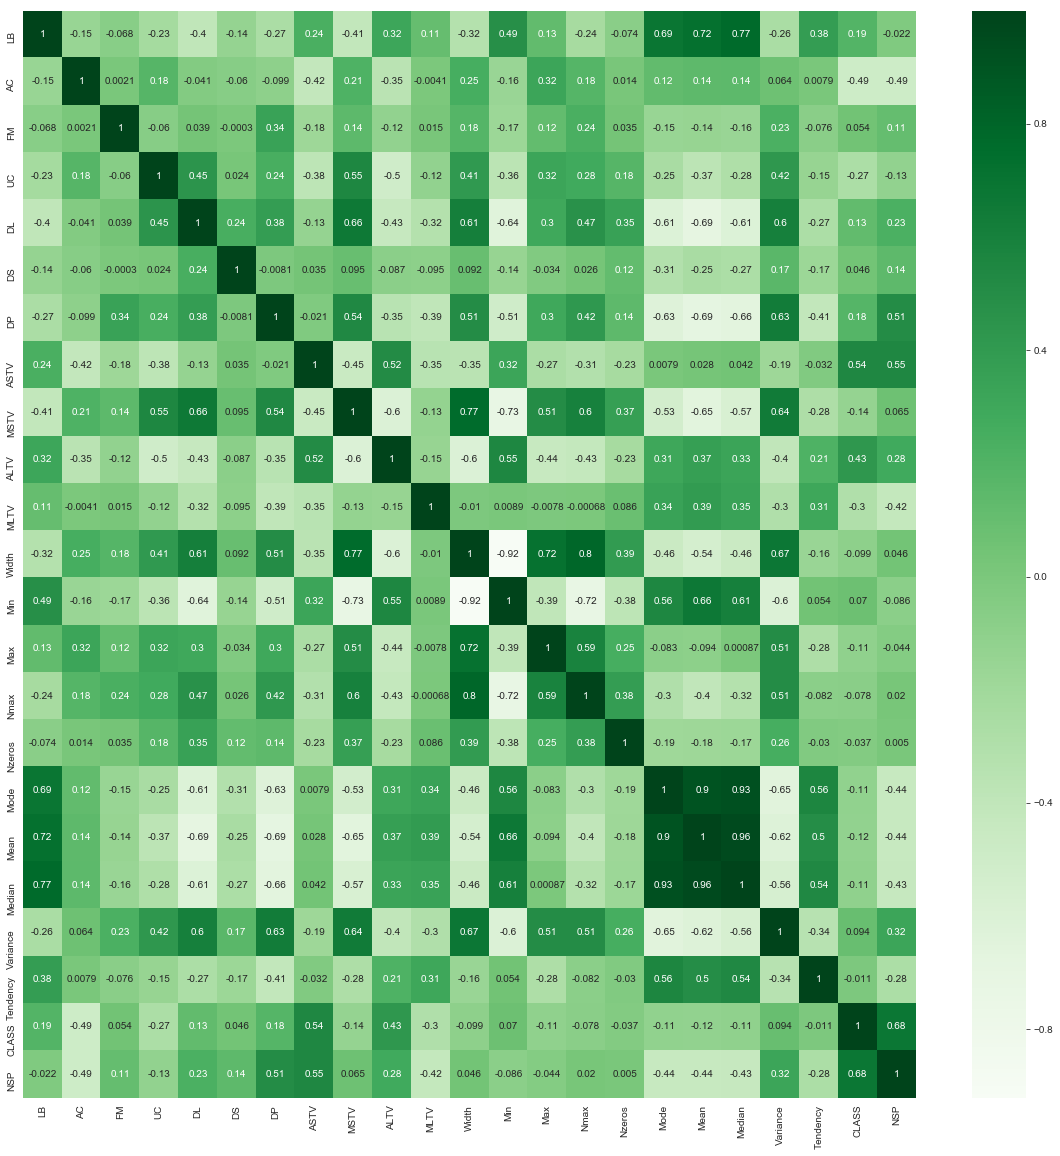

In [100]:
corrmat = df.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corrmat, annot=True, cmap="Greens")
plt.show()

# Model 1a: Baseline Decision Tree Model

## Baseline Decision Tree Model

In [101]:
# Imports for DT modeling and metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score, roc_curve, auc,classification_report

## We Will Use a 70/30 Train Test Split and Random Seed  = 10 for all Models

In [102]:
# Set up train test split (70/30). Train DT classifier with balanced class weights
X1 = feat2
y1 = df.NSP
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.30, random_state=10)
classifier1 = DecisionTreeClassifier(class_weight='balanced', random_state=10)
classifier1.fit(X_train1, y_train1)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=10,
            splitter='best')

In [103]:
y_pred1 = classifier1.predict(X_test1)

In [104]:
# Evaluation metrics for baseline DT Model
print(60*'-')
print('Baseline Decision Tree Model Using All Features')
print(60*'-')
acc1 = round((accuracy_score(y_test1, y_pred1)*100), 2)
print('Accuracy Score = {}%'.format(acc1))
print(60*'-')

report1 = classification_report(y_test1, y_pred1)
print(report1)
print(60*'-')

------------------------------------------------------------
Baseline Decision Tree Model Using All Features
------------------------------------------------------------
Accuracy Score = 95.57%
------------------------------------------------------------
              precision    recall  f1-score   support

           1       0.93      0.96      0.94       494
           2       0.95      0.93      0.94       486
           3       0.98      0.98      0.98       510

   micro avg       0.96      0.96      0.96      1490
   macro avg       0.96      0.96      0.96      1490
weighted avg       0.96      0.96      0.96      1490

------------------------------------------------------------


### Preliminary Evaluation: Baseline Decision Tree
* Overall accuracy looks good at 95% for first attempt.  
* This model looks good for overall consistency among the classes based on Precision, Recall, F1 Score and Accuracy
* We will optimize hyperparameters with gridsearch then re-run the model with these parameters
* We will then attempt to improve performance with the ensemble bagging classifier

In [105]:
# Write a Function to produce our Confusion Matrices throughout the project
def conf_matrix(y_actual, y_predicted, cmap='Blues'):
    class_names = ['Normal', 'Suspect', 'Pathologic']
    mat = confusion_matrix(y_actual, y_predicted)
    dataframe = pd.DataFrame(mat, index=class_names, columns=class_names)
    plt.figure(figsize=(10,5))
    sns.heatmap(dataframe, annot=True, cbar=None, cmap=cmap, fmt='.00f', annot_kws={"size":13})
    plt.title("Confusion Matrix", fontsize=18), plt.tight_layout()
    plt.ylabel("True Class",fontsize=15), plt.xlabel('Predicted Class', fontsize=15)
    plt.show()

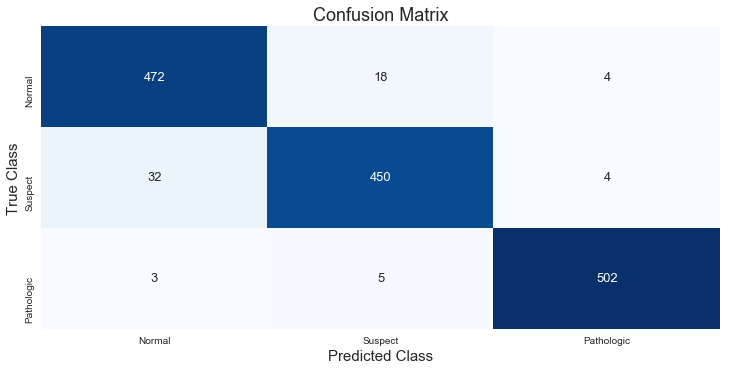

In [106]:
# Visualize Confusion Matrix For Baseline DT Model
conf_matrix(y_test1, y_pred1)

## Model Tuning and Feature Selection
* Identify the most important features for prediction. Eliminate features that do not help prediction.
* Adjust model parameters to see if we can improve overall performance

In [107]:
# Function to print the feature importances
def sort_importance_list(model_classifier, data=feat2):
    importances1 = model_classifier.feature_importances_
    features1 = data.columns
    features_importance1 = pd.DataFrame(importances1, index=features1, columns=['Importance'])
    sorted_feat_imp1 = features_importance1.sort_values('Importance', axis=0, ascending=False)
    return print(sorted_feat_imp1)
    

In [108]:
# Print the list of most important DT features
sort_importance_list(classifier1)

          Importance
Mean        0.286223
MSTV        0.227367
ALTV        0.141833
ASTV        0.119489
AC          0.058623
DP          0.032020
Min         0.017622
Max         0.016897
LB          0.016291
Mode        0.015784
Variance    0.011669
UC          0.010273
Nmax        0.009879
Median      0.008810
MLTV        0.008514
FM          0.007495
Tendency    0.005397
Width       0.003416
DL          0.002398
Nzeros      0.000000
DS          0.000000


In [109]:
# Function to visually inspect feature importances
def plot_feat_imp(model_classifier, data=feat2, color='r'):
    importances1 = model_classifier.feature_importances_
    features1 = data.columns
    features_importance1 = pd.DataFrame(importances1, index=features1, columns=['Importance'])
    sorted_feat_imp1 = features_importance1.sort_values('Importance', axis=0, ascending=False)
    plt.figure(figsize=(12,5))
    plt.title('Feature Importance in Model', fontsize=18)
    tmp = sorted_feat_imp1['Importance'].values.tolist()
    plt.bar(range(data.shape[1]), tmp, color=color )
    plt.xticks(range(data.shape[1]), sorted_feat_imp1.index, rotation=45, ha='center', fontsize=12)
    plt.xlim(-1, data.shape[1])
    plt.ylabel('Importance', fontsize=15)
    plt.tight_layout()
    plt.show()

## Feature Importances Baseline Decision Tree Model

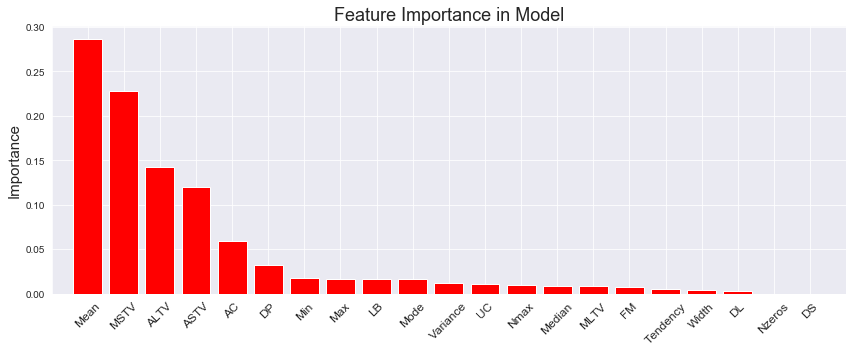

In [110]:
# Plot DT feature importances
plot_feat_imp(classifier1)

## Initial Grid Search with Cross Validation Revealed the following Optimum Parameters:
* {'criterion' : ['gini', "entropy"], = "gini"
* 'max_depth' : range(2,10), = 8
* 'max_features' : range(3,9), = 9
* 'max_leaf_nodes' : range(2,30), = 34
* 'min_samples_split' : range(2,10)} = 6
*  with 5 fold CV


## Note on DT Feature Importance:
* Our plot of feature Importannces shows 3 features heavily outweigh the others
* GridSearch shows the optimum features to be 9
* I tried the DT classifier and the bagged tree classifier (which uses the params of the DT clf) with 3,5,7,9 Features.
* 9 features appears to be the optimum.  The metrics were significantly reduced in all other cases.
* Comparison of the 10 fold CV, test and train accuracy in the final model are all almost exactly the same. It does not appear to be over or under fit.  It appears 9 features is optimal.

## Modified Second iteration with 10 fold CV (to save Comp time)

In [111]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

# Create a parameter grid: map the parameter names to the values that should be searched
param_grid1 = {'criterion' : ['gini'],
               'max_depth' : range(7,10),
               'max_features' : range(8,11),
               'max_leaf_nodes' : range(33,36),
               'min_samples_split' : range(5,8)}

# Instantiate the grid
grid1 = GridSearchCV(classifier1, param_grid1, cv=10, scoring='f1_macro')

# fit the grid with data
grid1.fit(X_train1, y_train1)



GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=10,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['gini'], 'max_depth': range(7, 10), 'max_features': range(8, 11), 'max_leaf_nodes': range(33, 36), 'min_samples_split': range(5, 8)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_macro', verbose=0)

In [112]:
# examine the best model

# Single best score achieved across all params 
print(grid1.best_score_)

# Dictionary containing the parameters used to generate that score
print(grid1.best_params_)

# Actual model object fit with those best parameters
# Shows default parameters that we did not specify
print(grid1.best_estimator_)


0.9262586716191664
{'criterion': 'gini', 'max_depth': 9, 'max_features': 9, 'max_leaf_nodes': 35, 'min_samples_split': 7}
DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=9,
            max_features=9, max_leaf_nodes=35, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=7, min_weight_fraction_leaf=0.0,
            presort=False, random_state=10, splitter='best')


# Model 1b: DT Model with Optimized Hyperparameters

In [113]:
# Set up train test split (70/30). Train DT classifier with balanced class weights and optimized parameters
X2 = feat2
y2 = df.NSP
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.30, random_state=10)
classifier2 = DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=9,
                       max_features=9, max_leaf_nodes=35,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=7,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=10, splitter='best')
classifier2.fit(X_train2, y_train2)
y_pred2 = classifier2.predict(X_test2)

## Feature Importances for DT with Optimized Hyperparameters

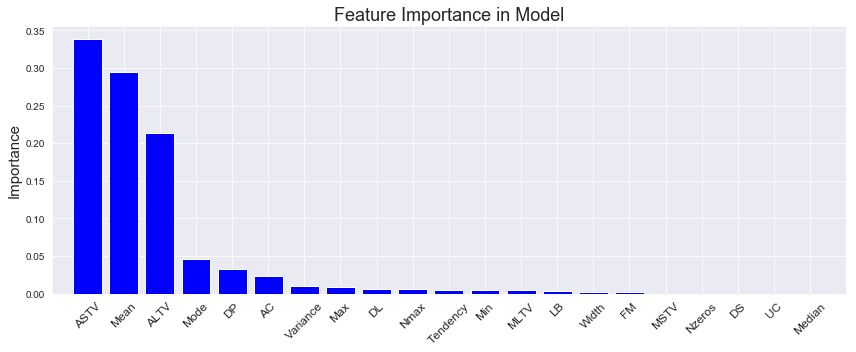

In [114]:
# Look at Overall Feature Importance
plot_feat_imp(classifier2, data=feat2, color='b')

In [115]:
# Evaluation metrics for Optimized DT Model
print(60*'-')
print('Optimized Decision Tree Model')
print(60*'-')
acc2 = round((accuracy_score(y_test2, y_pred2)*100), 2)
print('Accuracy Score = {}%'.format(acc2))
print(60*'-')

report2 = classification_report(y_test2, y_pred2)
print(report2)
print(60*'-')

------------------------------------------------------------
Optimized Decision Tree Model
------------------------------------------------------------
Accuracy Score = 93.62%
------------------------------------------------------------
              precision    recall  f1-score   support

           1       0.92      0.93      0.93       494
           2       0.93      0.90      0.91       486
           3       0.96      0.98      0.97       510

   micro avg       0.94      0.94      0.94      1490
   macro avg       0.94      0.94      0.94      1490
weighted avg       0.94      0.94      0.94      1490

------------------------------------------------------------


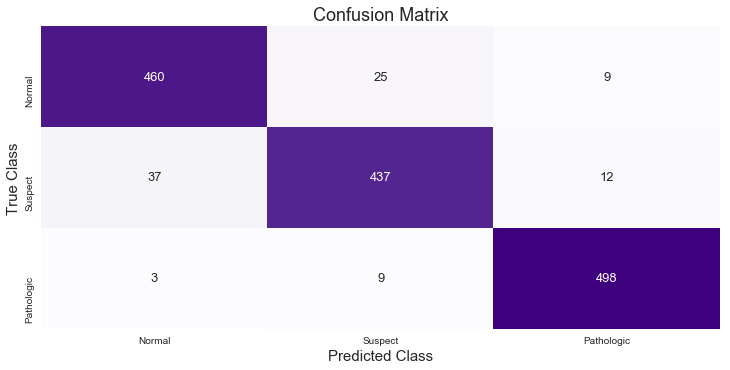

In [116]:
# Visualize the confusion matrix for DT with optimized hyperparameters
conf_matrix(y_test2, y_pred2, cmap='Purples')

# Model 1c: Optimized DT model with the Ensemble Bagging Classifier
* We found the best hyperparameters for our Decision Tree with GridSearchCV
* Bootstrap aggregating or bagging will increase the stability and accuracy of our DT Model.
* It will reduce variance and help to avoid ovefitting. Bagging is a special case of the model averaging approach

In [117]:
# Import The BaggingClassifier
from sklearn.ensemble import BaggingClassifier

In [118]:
# Fit Our Bagged Tree Model
bagged_tree =  BaggingClassifier(classifier2, n_estimators=20, random_state=10)
bagged_tree.fit(X_train2, y_train2)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=9,
            max_features=9, max_leaf_nodes=35, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=7, min_weight_fraction_leaf=0.0,
            presort=False, random_state=10, splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=20, n_jobs=None, oob_score=False,
         random_state=10, verbose=0, warm_start=False)

In [119]:
# 10 fold CV of the Bagged Tree Model
bagged_pred = bagged_tree.predict(X_test2)
bagged_kf = KFold(n_splits=10, shuffle=True, random_state=10)
bagged_cv_results = cross_val_score(bagged_tree, X2, y2, cv=bagged_kf, scoring="accuracy",n_jobs=-1) 

## Evaluation of Our Best DT model: Bagged Decision Tree

In [120]:
print(60*'-')
print("10 fold Bagged Tree CV score: {}".format(bagged_cv_results.mean()))
print('Bagged Tree Train Score: {}'.format(bagged_tree.score(X_train2, y_train2)))
print('Bagged Tree Test Score: {}'.format(bagged_tree.score(X_test2, y_test2)))  
print(60*'-')
print('Bagged Decision Tree Ensemble Method')
print(60*'-')
report_bagged = classification_report(y_test2, bagged_pred)
print(report_bagged)
print(60*'-')

------------------------------------------------------------
10 fold Bagged Tree CV score: 0.9510591776465243
Bagged Tree Train Score: 0.9628776978417266
Bagged Tree Test Score: 0.9530201342281879
------------------------------------------------------------
Bagged Decision Tree Ensemble Method
------------------------------------------------------------
              precision    recall  f1-score   support

           1       0.95      0.94      0.95       494
           2       0.93      0.94      0.94       486
           3       0.97      0.97      0.97       510

   micro avg       0.95      0.95      0.95      1490
   macro avg       0.95      0.95      0.95      1490
weighted avg       0.95      0.95      0.95      1490

------------------------------------------------------------


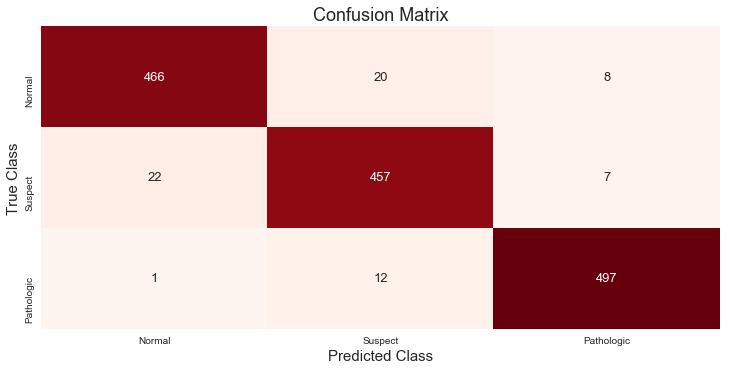

In [121]:
# Visualize the Confusions Matrix for DT with optimized hyperparameters using the ensemble Bagging Classifier
conf_matrix(y_test2, bagged_pred, cmap='Reds')

# Conclusions from Decision Tree Modeling
* Our first model performed well.  With an overall accuracy of 95%.  
* All features were scaled using the Robust Scaler and all were included in the modeling.
* We then performed an extensive grid search with 10 fold cross validation to find the optimized hyperparameters for this model
* The performance of our model suffered in terms of accuracy, F1 score, precision and recall
* The overall accuracy was reduced to 93%.  And the individual metrics among the classes dropped slightlyy as well
* This is more than likely due to initial ovefitting of the model by including all features and not restricting any of the model parameters. Decision Trees are vulnerable to overfitting
* With Bagging and optimized hyperparameters we greatly improved results while decresing the chances of overfitting
* The Bagged Tree Model was the best of the three Decision Tree Models
* This model had overall Accuracy, F1, Precision and Recall all at 95%


# Model 2a: Baseline Random Forest Ensemble Method


## EDA and Explore preliminary RF model
* We will continue to model using our scaled data
* We will continue to use the "balanced" Class parameter to compensate for our class imbalance
* We will investigate the performance of an initial model and then adjust hyperparameters accordingly

In [122]:
# Set up and fit the intital Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
rf_clf1 = RandomForestClassifier(class_weight='balanced', n_estimators=75, max_depth=5, random_state=10)
rf_clf1.fit(X_train2, y_train2)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=5, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=75, n_jobs=None, oob_score=False, random_state=10,
            verbose=0, warm_start=False)

In [123]:
# Access the performance of our Intial RF Model
rf_pred = rf_clf1.predict(X_test2)
print(60*'-')
print('Random Forest1 Ensemble Method Initial Model')
print(60*'-')
report_bagged = classification_report(y_test2, rf_pred)
print(report_bagged)
print(60*'-')

------------------------------------------------------------
Random Forest1 Ensemble Method Initial Model
------------------------------------------------------------
              precision    recall  f1-score   support

           1       0.95      0.89      0.92       494
           2       0.86      0.95      0.90       486
           3       0.98      0.94      0.96       510

   micro avg       0.93      0.93      0.93      1490
   macro avg       0.93      0.93      0.93      1490
weighted avg       0.93      0.93      0.93      1490

------------------------------------------------------------


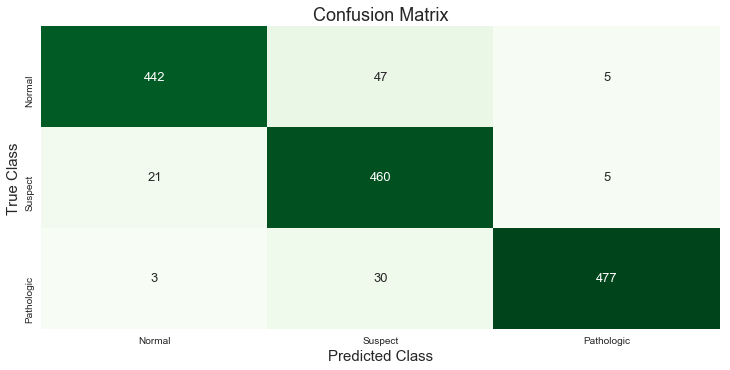

In [124]:
# Confusion Matrix for Baseline Random Forest Model
conf_matrix(y_test2, rf_pred, cmap='Greens')

## Feature Importance Baseline Random Forest Model

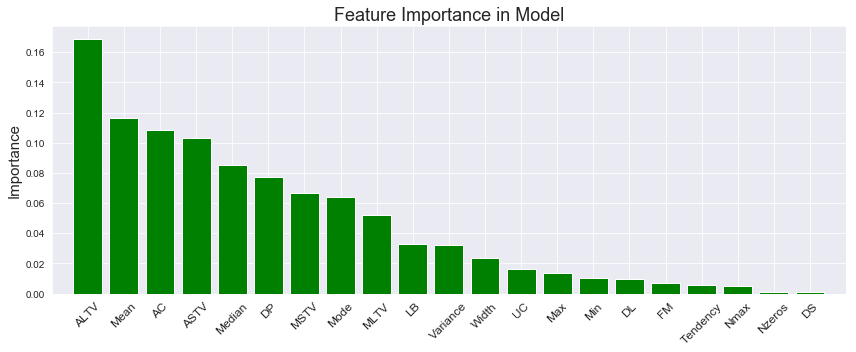

In [125]:
# Look at Overall Feature Importance
plot_feat_imp(rf_clf1, data=feat2, color='g')

In [126]:
rf_tree_1 = rf_clf1.estimators_[0]
rf_tree_3 = rf_clf1.estimators_[2]

### Feature Importances for RF Tree 1

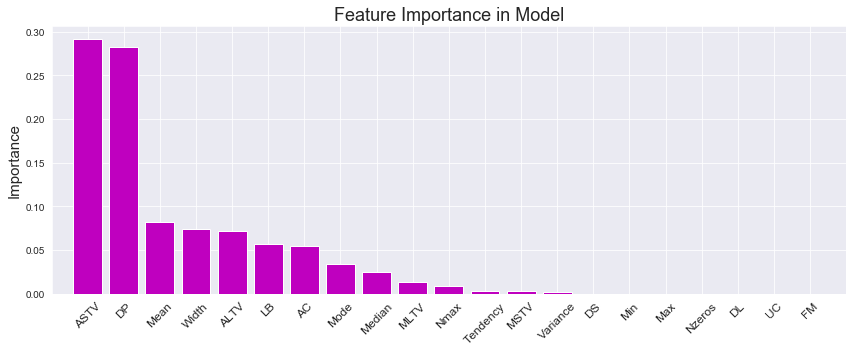

In [127]:
# View the feature Importance of Our first Tree
plot_feat_imp(rf_tree_1, data=feat2, color='m')

### Feature importance for RF Tree 3

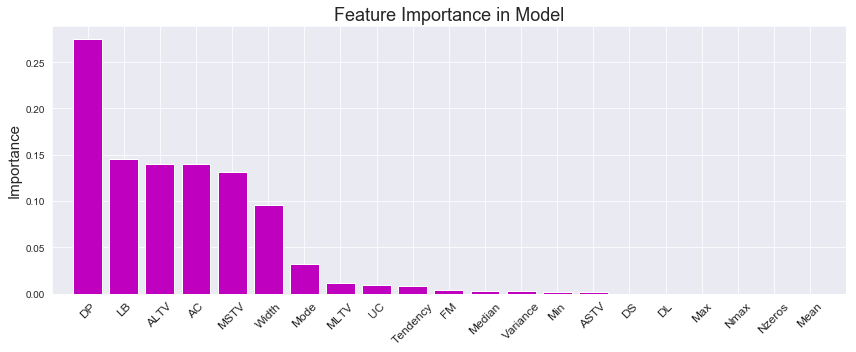

In [128]:
# Feature importance of the 3rd tree
plot_feat_imp(rf_tree_3, data=feat2, color='m')

### Intial Thoughts and Findings
* As we saw before not all features have equal importance.
* Each tree in the Forest will have different importances for features
* This why Random Forest is an Ensemble method and has its value in this. Multiple trees with different importances will be grown and the overal model will be an "average" or summary of these
* We will investigate tuning the parameters for better performance
* We saw an overall good performance to start with

## Lets look visually at how the number of trees will affect our model

In [129]:
# Validation curve for N_trees between 1 and 100
from sklearn.model_selection import validation_curve
n_trees_train_scores, n_trees_test_scores = validation_curve(RandomForestClassifier(class_weight='balanced',random_state=10),
                                            X2, y2, 
                                            param_name='n_estimators',
                                            param_range= np.arange(1, 100, 2),
                                            cv=3, scoring = "accuracy", n_jobs=-1
                                            )

In [130]:
# Function for plotting Validation Curve for feature visualization and selection
def plot_feat_val_curve(train_scores, test_scores, feat_label='Number of Trees', param_range= np.arange(1, 100, 2)):
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    plt.figure(figsize=(15,6))
    plt.plot(param_range, train_mean, label= "Training Score", color = "black")
    plt.plot(param_range, test_mean, label= "Cross Validation Score", color='red')
    plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color='gray')
    plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color='gainsboro')
    plt.title("Validation Curve With Random Forest", fontsize=18)
    plt.xlabel(feat_label, fontsize=15)
    plt.ylabel("Accuracy Score", fontsize=15)
    plt.tight_layout()
    plt.legend(loc="best")
    plt.show()

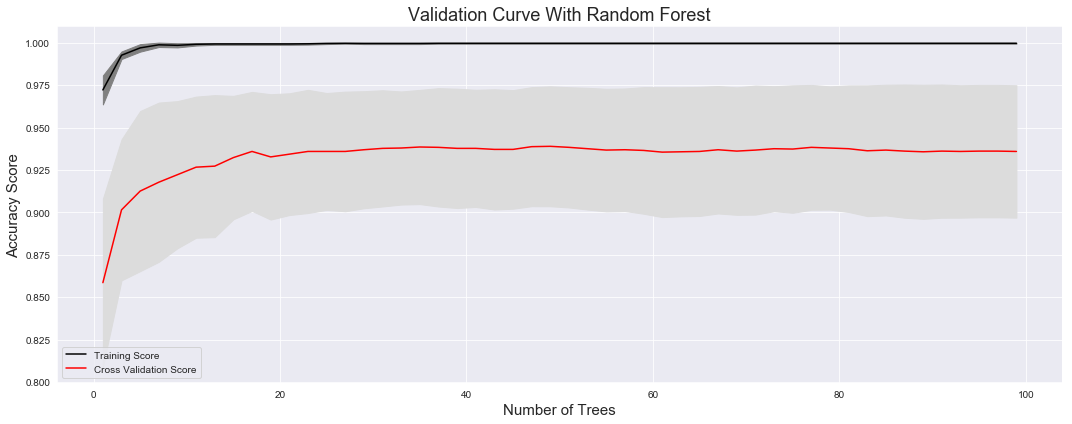

In [131]:
plot_feat_val_curve(n_trees_train_scores, n_trees_test_scores)

### We can see that our scores level out with number of trees greater than 25

## Visually look at optimum max_depth of our forest

In [132]:
depth_train_scores, depth_test_scores = validation_curve(RandomForestClassifier(class_weight='balanced',random_state=10),
                                            X2, y2, 
                                            param_name='max_depth',
                                            param_range= np.arange(1, 25, 2),
                                            cv=3, scoring = "accuracy", n_jobs=-1
                                            )

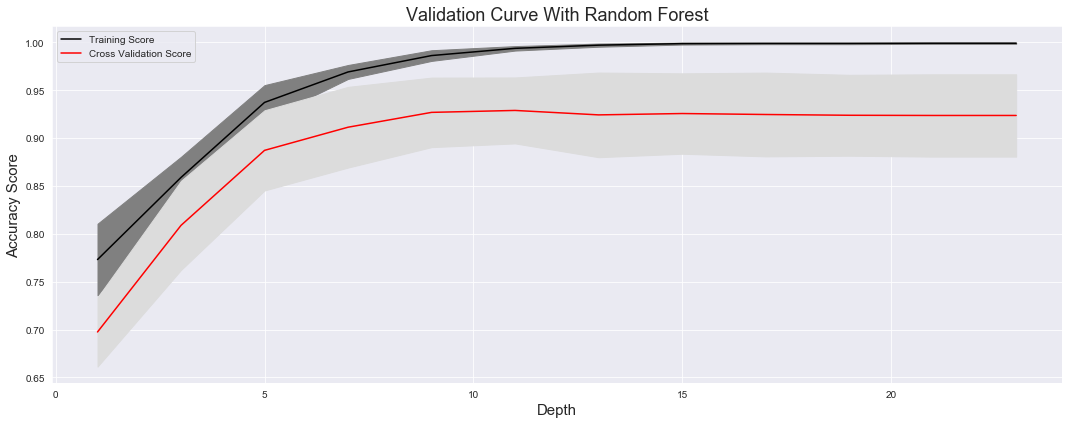

In [133]:
plot_feat_val_curve(depth_train_scores, depth_test_scores, feat_label='Depth', param_range= np.arange(1, 25, 2))

### We can see that our Max depth should be somewhere between 9 and 10

# Model 2b: Random Forest Model with Adjusted Hyperparameters

In [134]:
# Fit Random Forest Model with Adjusted Hyperparameters
rf_clf2 = RandomForestClassifier(class_weight='balanced', n_estimators=25, max_depth=9, random_state=10)
rf_clf2.fit(X_train2, y_train2)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=9, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=25, n_jobs=None, oob_score=False, random_state=10,
            verbose=0, warm_start=False)

## Feature Importances for Random Forest Model with Adjusted Hyperparameters

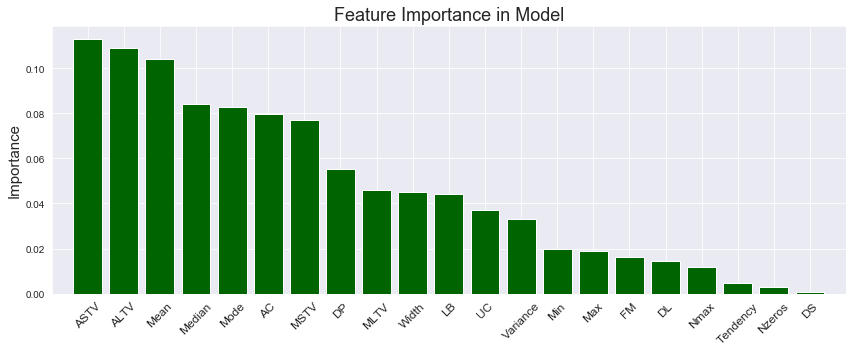

In [135]:
# Look at Overall Feature Importance
plot_feat_imp(rf_clf2, data=feat2, color='darkgreen')

## 10-Fold Cross Validation and Final RF Model Evaluation

In [136]:
from sklearn.model_selection import KFold, cross_val_score
kf = KFold(n_splits=10, shuffle=True, random_state=10)
rf_cv_results = cross_val_score(rf_clf2, X2, y2, cv=kf, scoring="accuracy",n_jobs=-1) 

In [137]:
# Access the performance of our Modified RF Model
rf_pred2 = rf_clf2.predict(X_test2)
print(60*'-')
print('Random Forest Final Model')
print(60*'-')
print("10 Fold RF Cross Validation Mean: {}".format(rf_cv_results.mean()))
print("RF Final Train Scores: {}".format(rf_clf2.score(X_train2, y_train2)))
print("RF Final Test Scores: {}".format(rf_clf2.score(X_test2, y_test2)))
print(60*'-')
report_bagged = classification_report(y_test2, rf_pred)
print(report_bagged)
print(60*'-')

------------------------------------------------------------
Random Forest Final Model
------------------------------------------------------------
10 Fold RF Cross Validation Mean: 0.9681772084117611
RF Final Train Scores: 0.9830215827338129
RF Final Test Scores: 0.9684563758389262
------------------------------------------------------------
              precision    recall  f1-score   support

           1       0.95      0.89      0.92       494
           2       0.86      0.95      0.90       486
           3       0.98      0.94      0.96       510

   micro avg       0.93      0.93      0.93      1490
   macro avg       0.93      0.93      0.93      1490
weighted avg       0.93      0.93      0.93      1490

------------------------------------------------------------


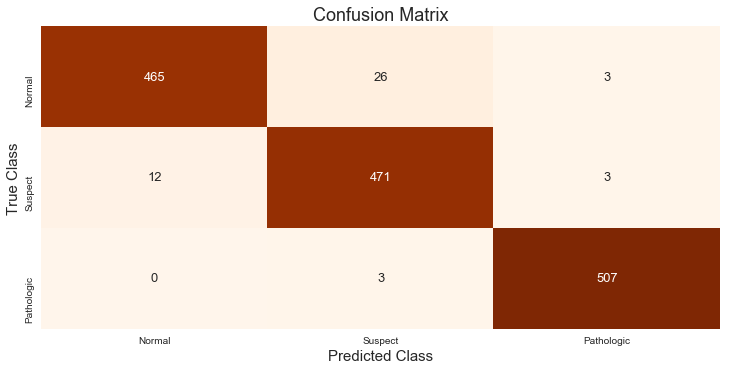

In [138]:
# Confusion Matrix for Final Random Forest Model
conf_matrix(y_test2, rf_pred2, cmap='Oranges')                          

## We Have Achieved Nice Results with DT and RF Models
* As we used a bagging ensemble technique with our Decision Tree, lets try Gradient Booosting using some of the information we gained about our hyperparameters using our Random Forest Model

# Model 2c: Gradient Boosting Classifier with Optimized Hyperparameters
* Experimented with learning rate (.05, .08, .1, 1.2), features (7-12), min_samples_split (2,4,6,10), min_sample_leaf(1,3,5,10)
* None achieved as high or as consistent scores across all parameters
* I was woried about over or underfitting or not maximizing score.  So i tried the above.
* Train score is only sightly higher than test (<2%) but i think that is to be expected
* The results are so tightly grouped and consitent across all 10 fold cross validated metrics I am confident in this model and the settings
* this is by far the best performing Model

In [139]:
# Train GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier
gbt_clf = GradientBoostingClassifier(n_estimators=25, max_depth=9, random_state=10, max_features=8, learning_rate=0.09)
gbt_clf.fit(X_train2, y_train2)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.09, loss='deviance', max_depth=9,
              max_features=8, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=25,
              n_iter_no_change=None, presort='auto', random_state=10,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

## Feature Importance for GradientBoostingClassifier

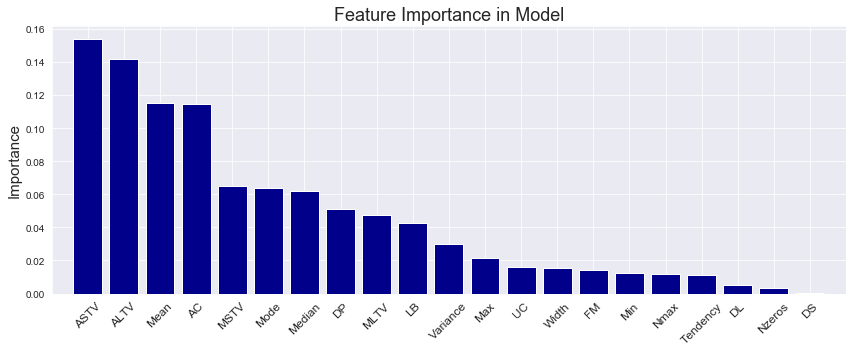

In [140]:
# Feature Importances for GradientBoostingClassifier
plot_feat_imp(gbt_clf, data=feat2, color='darkblue')

## Top 8 features Final Model: How They Differ Between Class

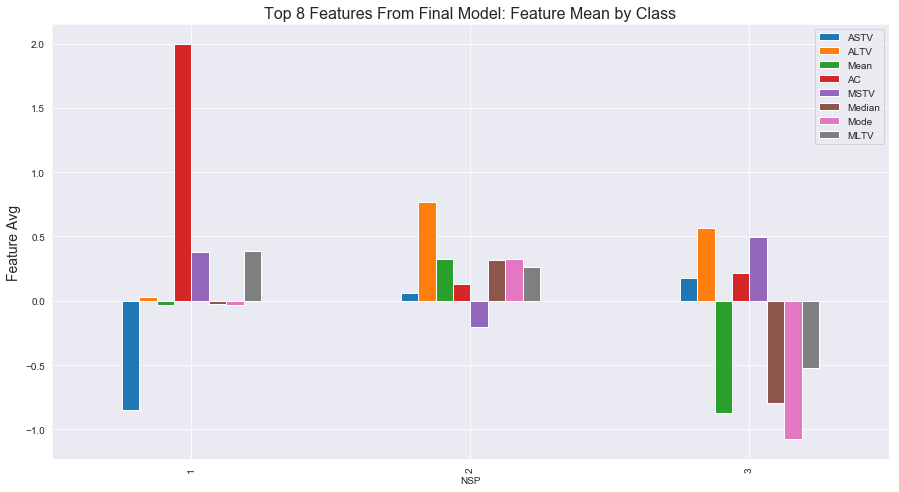

In [141]:
df_tf = pd.concat([feat2, df.NSP], axis=1)
topfeatures =['ASTV', 'ALTV', 'Mean', 'AC', 'MSTV', 'Median', 'Mode', 'MLTV']
df_tf.groupby('NSP')[topfeatures].mean().plot.bar(figsize=(15,8))
plt.legend(loc='best')
plt.title('Top 8 Features From Final Model: Feature Mean by Class', fontsize=16)
plt.ylabel('Feature Avg', fontsize=14)
plt.show()

## Gradient Boosting Classifier 10 Fold CV: Accuracy, Precision, Recall and F1 Score

In [142]:
# 10 fold Cross-validation Accuracy
gbt_kf = KFold(n_splits=10, shuffle=True, random_state=10)
gbt_cv_results_a = cross_val_score(gbt_clf, X2, y2, cv=gbt_kf, scoring="accuracy",n_jobs=-1) 
gbt_pred = gbt_clf.predict(X_test2)

In [143]:
# 10 fold Cross-validation Precision
gbt_cv_results_p = cross_val_score(gbt_clf, X2, y2, cv=gbt_kf, scoring="precision_weighted",n_jobs=-1)

In [144]:
# 10 fold Cross-validation Recall
gbt_cv_results_r = cross_val_score(gbt_clf, X2, y2, cv=gbt_kf, scoring="recall_weighted",n_jobs=-1)

In [145]:
# 10 fold Cross-validation F1 score
gbt_cv_results_f = cross_val_score(gbt_clf, X2, y2, cv=gbt_kf, scoring="f1_weighted",n_jobs=-1)

In [146]:
# Classification Report for Gradient Boosting Classifier
print(90*'-')
print('Gradient Boosting Classifier Model Final Model')
print(90*'-')
print("F1: 10 Fold Gradient Boosting Classifier Cross Validation: {}".format(gbt_cv_results_f.mean()))
print("Recall: 10 Fold Gradient Boosting Classifier Cross Validation: {}".format(gbt_cv_results_r.mean()))
print("Precision: 10 Fold Gradient Boosting Classifier Cross Validation: {}".format(gbt_cv_results_p.mean()))
print("Accuracy: 10 Fold Gradient Boosting Classifier Cross Validation: {}".format(gbt_cv_results_a.mean()))
print("Gradient Boosting Classifier Final Train Scores: {}".format(gbt_clf.score(X_train2, y_train2)))
print("Gradient Boosting Classifier Final Test Scores: {}".format(gbt_clf.score(X_test2, y_test2)))
print(90*'-')
report_gbt = classification_report(y_test2, gbt_pred)
print(report_gbt)
print(90*'-')

------------------------------------------------------------------------------------------
Gradient Boosting Classifier Model Final Model
------------------------------------------------------------------------------------------
F1: 10 Fold Gradient Boosting Classifier Cross Validation: 0.9800750517733222
Recall: 10 Fold Gradient Boosting Classifier Cross Validation: 0.9800614168884275
Precision: 10 Fold Gradient Boosting Classifier Cross Validation: 0.9803919635650793
Accuracy: 10 Fold Gradient Boosting Classifier Cross Validation: 0.9800614168884275
Gradient Boosting Classifier Final Train Scores: 0.9997122302158273
Gradient Boosting Classifier Final Test Scores: 0.9798657718120806
------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           1       0.98      0.97      0.97       494
           2       0.98      0.97      0.97       486
           3       0.99      0.99      0.99       510

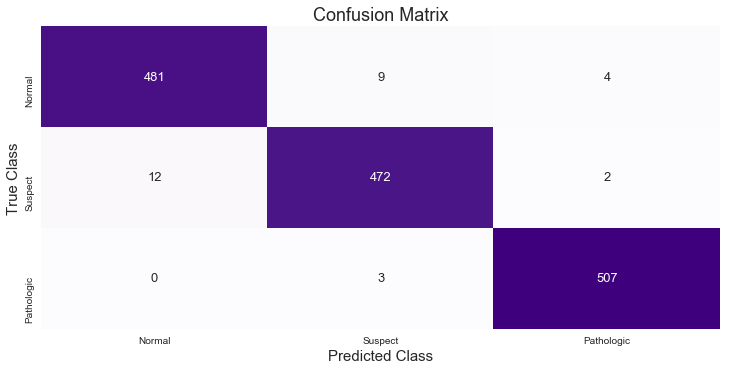

In [147]:
# Confusion Matrix for Gradient Boosting Classifier
conf_matrix(y_test2, gbt_pred, cmap='Purples')

## We can see that Gradient Boosting Significantly Improved our Model


## Conclusions from Random Forest Modeling and gradient Boosting Classifier
* The Decision Tree, Bagged Tree and Random Forest models all performed fairly well.  But still had some difficulty predicting Class 2 on par with the other two Classes.
* The Gradient Boosted Classifier Outperformed all other models.  It performed the best for the most critical class, the Pathological class, but also performed consistently well across every class and metric.
* This model had 10 fold cross validated scores of 98% for all four metrics: Accuracy, F1, Precision and Recall
* the visualization of the 10 fold cross validated metrics also show a very tight grouping (small standard deviation)
* This is the highest scoring and most consistent model in all evaluation metric
* This is the highest performing and most consistent of all our models

# Model 3a: Baseline SVM with RBF Kernel

## Start with a base SVM Model using RBF Kernel
* Continue to keep class_weight "balanced" and random state=10
* Look at intitial Model and then gridsearch for C and gamma

In [148]:
# Train initial SVM Model using RBF kernel and default C and gamma
from sklearn.svm import SVC
svm_model = SVC(C=1, gamma='auto_deprecated', class_weight='balanced', random_state=10)
svm_model.fit(X_train2, y_train2)

SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=10,
  shrinking=True, tol=0.001, verbose=False)

## Evaluation of Baseline SVM Model

In [149]:
# Classification report for baseline SVM
svm_pred = svm_model.predict(X_test2)
report_svm = classification_report(y_test2, svm_pred)

In [150]:
# Print Classification report for baseline SVM
print(report_svm)
print(60*'-')

              precision    recall  f1-score   support

           1       0.98      0.89      0.93       494
           2       0.88      0.92      0.90       486
           3       0.92      0.95      0.94       510

   micro avg       0.92      0.92      0.92      1490
   macro avg       0.92      0.92      0.92      1490
weighted avg       0.92      0.92      0.92      1490

------------------------------------------------------------


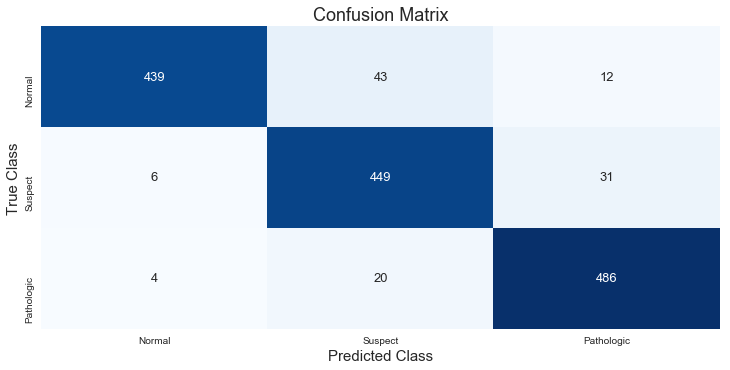

In [151]:
# Confusion Matrix for baseline SVM
conf_matrix(y_test2, svm_pred, cmap='Blues')

## Perform GridSearchCV for C and gamma parameters of SVM
* Tried C = [1, 2, 5, 100] = 100 (3 fold)
* Tried C = [10, 20, 50, 100] = 100 (3 fold)
* Tried C = [100, 150, 200, 500] = 100 (3 fold)
* Tried C = [90, 100, 110, 120] = 110 (3 fold)
* Tried C = [100, 102, 105, 110] = 110 (5 fold)
* Optimized C = 110
* Tried gamma = [1, .05, 0.15, .05, .01, .005, .001]
* gamma = 0.1 in all cases tried
* Optimized gamma = 0.1

In [152]:
# GridSearchCV for SVM
param_grid2 = {'C': [100, 102, 105, 110], 'gamma': [0.12, 0.1, .08, .01]}
# Instantiate the grid
svm_grid = GridSearchCV(svm_model, param_grid2, cv=5, scoring='accuracy')
# fit the grid with data
svm_grid.fit(X_train2, y_train2)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=10,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [100, 102, 105, 110], 'gamma': [0.12, 0.1, 0.08, 0.01]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [153]:
# Single best score achieved across all params 
print(svm_grid.best_score_)

# Dictionary containing the parameters used to generate that score
print(svm_grid.best_params_)

0.9620143884892086
{'C': 110, 'gamma': 0.1}


# Model 3b: SVM Model with Optimized Hyperparameters

In [154]:
# Fit SVM Model with optimized hyperparameters
svm_model2 = SVC(C=110, gamma=0.1, class_weight='balanced', random_state=10)
svm_model2.fit(X_train2, y_train2)

SVC(C=110, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=10, shrinking=True,
  tol=0.001, verbose=False)

## SVM 10 Fold Cross Validation: Accuracy, Precision, Recall and F1 Score

In [155]:
# 10 fold Cross-validation Accuracy
svm_kf = KFold(n_splits=10, shuffle=True, random_state=10)
svm_cv_results_a = cross_val_score(svm_model2, X2, y2, cv=svm_kf, scoring="accuracy",n_jobs=-1) 
svm_pred2 = svm_model2.predict(X_test2)

In [156]:
# 10 fold Cross-validation Precision
svm_cv_results_p = cross_val_score(svm_model2, X2, y2, cv=svm_kf, scoring="precision_weighted",n_jobs=-1) 

In [157]:
# 10 fold Cross-validation Recall
svm_cv_results_r = cross_val_score(svm_model2, X2, y2, cv=svm_kf, scoring="recall_weighted",n_jobs=-1)

In [158]:
# 10 fold Cross-validation F1
svm_cv_results_f = cross_val_score(svm_model2, X2, y2, cv=svm_kf, scoring="f1_weighted",n_jobs=-1)

## 10-Fold CV Evaluation Metrics for Final SVM Model

In [159]:
print(60*'-')
print('SVM Final Model')
print(60*'-')
print("F1: 10 Fold SVM Cross Validation: {}".format(svm_cv_results_f.mean()))
print("Recall: 10 Fold SVM Cross Validation: {}".format(svm_cv_results_r.mean()))
print("Precision: 10 Fold SVM Cross Validation: {}".format(svm_cv_results_p.mean()))
print("Accuracy: 10 Fold SVM Cross Validation: {}".format(svm_cv_results_a.mean()))
print("SVM Final Train Scores: {}".format(svm_model2.score(X_train2, y_train2)))
print("SVM Final Test Scores: {}".format(svm_model2.score(X_test2, y_test2)))
print(60*'-')
report_svm = classification_report(y_test2, svm_pred2)
print(report_svm)
print(60*'-')

------------------------------------------------------------
SVM Final Model
------------------------------------------------------------
F1: 10 Fold SVM Cross Validation: 0.9739733959384544
Recall: 10 Fold SVM Cross Validation: 0.9740146524307132
Precision: 10 Fold SVM Cross Validation: 0.9742404284117236
Accuracy: 10 Fold SVM Cross Validation: 0.9740146524307132
SVM Final Train Scores: 0.9933812949640288
SVM Final Test Scores: 0.9704697986577181
------------------------------------------------------------
              precision    recall  f1-score   support

           1       0.97      0.96      0.96       494
           2       0.96      0.96      0.96       486
           3       0.98      1.00      0.99       510

   micro avg       0.97      0.97      0.97      1490
   macro avg       0.97      0.97      0.97      1490
weighted avg       0.97      0.97      0.97      1490

------------------------------------------------------------


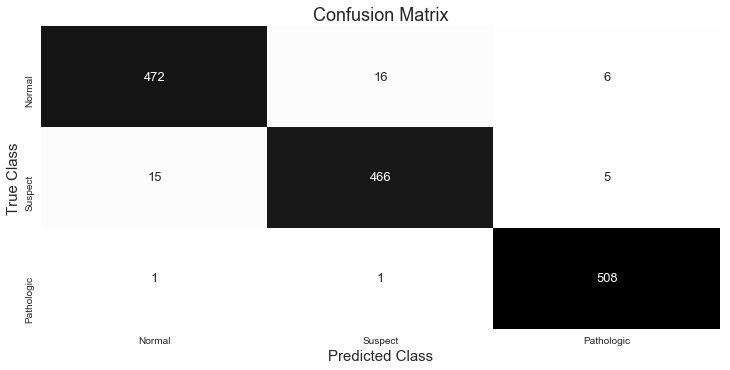

In [160]:
# Confusion Matrix for Final SVM Model
conf_matrix(y_test2, svm_pred2, cmap='Greys')

# Conclusions for SVM Model with RBF Kernel
* The SVM Model did very well with 10-fold cross validation scores of 97.4% across all four metrics.
* It is a close second in terms of model strength compared to the Gradient Boosted CLF model
* As can be seen in the visualization below standard deviation and IQR are larger for this model
* The Gradient Boosted CLF much narrower prediction window as well as higher overall scores.
* This is still a good and useful model

# Comparison of our Best Models

In [161]:
# Define Variables for Plot
res = [bagged_cv_results, rf_cv_results, gbt_cv_results_a, svm_cv_results_a]
names = ['BAGGED DT', 'RANDOM FOREST', 'GRADIENT BOOSTED CLF', 'SVM']

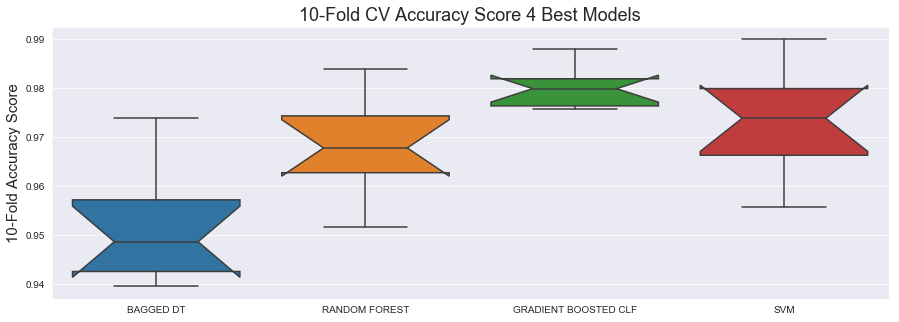

In [162]:
# Plot the 4 best models comparing 10-fold cross validated Accuracy score
plt.figure(figsize=(15,5))
sns.boxplot(x=names, y=res, notch=True)
plt.title('10-Fold CV Accuracy Score 4 Best Models', fontsize=18)
plt.ylabel('10-Fold Accuracy Score', fontsize= 15)
plt.show()

In [163]:
# Function for plotting the 10 fold cross validated score metrics for top 2 models
def cv_plots(res_a=gbt_cv_results_p, res_b=svm_cv_results_p, descr='Precision'):
    names = ['GRADIENT BOOSTED CLF', 'SVM']
    res2 = [res_a, res_b]
    plt.figure(figsize=(15,5))
    sns.boxplot(x=names, y=res2, notch=True)
    plt.title('10-Fold CV {} Score Top 2 Models'.format(descr), fontsize=18)
    plt.ylabel('10-Fold {} Score'.format(descr), fontsize= 15)
    plt.show()

## 10-Fold Cross Validated Precision Score Gradient Boosted CLF vs SVM

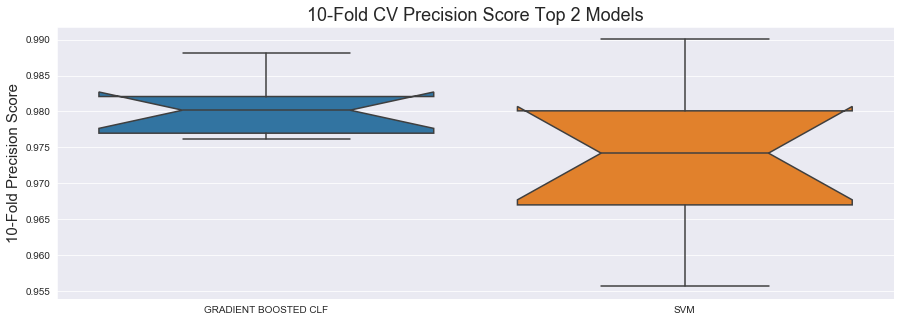

In [164]:
# Plot the 10 fold cross validated Precision Score for top 2 models
cv_plots()

## 10-Fold Cross Validated Recall Score Gradient Boosted CLF vs SVM

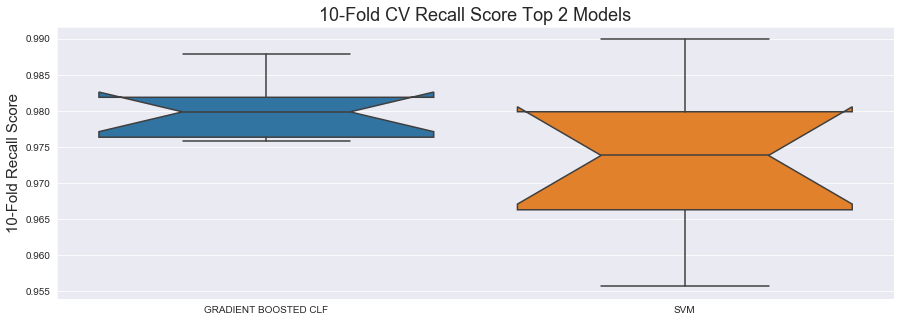

In [165]:
# Plot the 10 fold cross validated Recall Score for top 2 models
cv_plots(res_a=gbt_cv_results_r, res_b=svm_cv_results_r, descr='Recall')

## 10-Fold Cross Validated F1 Score Gradient Boosted CLF vs SVM

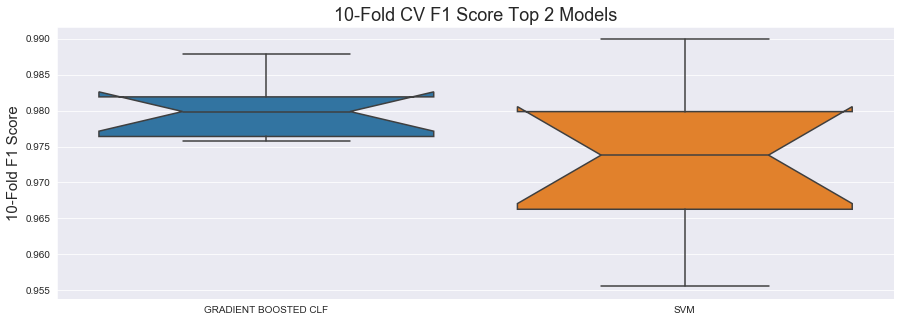

In [166]:
# Plot the 10 fold cross validated F1 Score for top 2 models
cv_plots(res_a=gbt_cv_results_f, res_b=svm_cv_results_f, descr='F1')

# Conclusion: Gradient Boosted CLF is Best Model for Predicting CTG results
* The Gradient Boosted CLF and SVM Models both had impressive results
* SVM had 10-fold cross validated scores of 97.4% for Precision, Recall, Accuracy and F1 score. However, from the graph above we can see the values in this 10-fold cross validation ranged over almost 4 %
* Gradient Boosted CLF had 10-fold cross validated scores of 98% for Precision, Recall, Accuracy and F1 score. And it can be seen that all values were tightly grouped and ranged only close to 1%.  A much smaller standard deviation
* This means we can expect much better consistency from this model.
* The Gradient Boosted CLF model best minimized the most important types of error we were trying to avoid.
* This model had the fewest misclassified Suspicious and Pathological cases at only 1.2%.  This is most important from a medical perspective.  Having cases that need medical attention be classified as Normal and go untreated.
* This model also had the fewest Normal case classified as Suspicious or Abnormal 2.2%. This is important from an unnecessary cost perspective.
* These are both very low numbers and certainly within the tolerance of a useful diagnostic tool.

# Cost-Benefit Analysis from a Medical Diagnostic Tool Perspective
* Almost no medical testing procedure is 100% accurate in all cases.  One must weigh the consequences of false outcomes in a medical test.
* Medical tests seek to avoid false negative outcomes. This means a patient, or in this case an unborn fetus, in need of medical attention will go untreated.
* A good medical test also seeks to avoid as many false positive outcomes as possible.  This means a healthy subject is classified as unhealthy. This leads to means the patient could undergo unnecessary medical treatment which is costly and stressful to the patient.
* The is particularly true if this means invasive procedures such as surgery or chemotherapy.
* In our case the downstream treatments are not as harsh or costly but still need to be minimized. Further monitoring and CTG are non-invasive and less expensive by medical standards. Healthy individuals that were misdiagnosed by this test would likely be found to be normal through further monitoring.
* If the case of Suspicious and Abnormal cases. Our concern was less if these classes were switched.  Both would be subject to further monitoring and the true nature of the case will more than likely be determined by other methods.
* Our model did well in all areas but specifically the two areas of most concern
* First Concern False negatives. Classifying a fetus that is suspect or pathological as healthy. This means a potential problem pregnancy could go untreated.
* 0/508 Pathological called Normal:
* 12/486 Suspect called Normal:
* Critical false negatives cases: 12/994 = 1.2%
* Critical false positive cases: Normal called either Pathological or Suspicious = 12/494 = 2.4%
* This test performed well in both cases. Well within the tolerance of a useful diagnostic tool

# Future Directions:
* I believe this is solid model with real Potential as a medical diagnostic tool. The metrics from this test are as good or better than any I have seen in published literature
* As always, the real test is more data.  This model needs to be tested against new data that it has never seen before for true evaluation.  It is the life cycle and workflow of any modeling project.  Put forth your best model trained and validated on all available data then test against new data.
* Then re-optimize the model and re-deploy.
* I chose the three model types most cited in the literature. Then I investigated these along with Ensemble methods. The other main model use in the literature was the Naive Bayes model. However, this was usually tried but did not perform as well as other models.
* I think I have found a very useful and reliable model
* I do not have experience using them yet, but my gut feeling is the only thing that can rival this model will be deep neural networks.  I would like to try that when I am introduced to them
* I have also considered making this a two-class classification problem.  Abnormal vs Normal.  However, after further investigation I have found out that the classification rules and procedures are governed by medical boards like FIGO listed in the introduction. 
* In 2015 they redefined the diagnostic classifications of CTG to specifically be Normal, Suspect and Pathological.
* If this is to be a tool useful for real world medical diagnostics it is probably better to stay within those confines


# THANK YOU!